In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [3]:
df=read_data('German.csv')

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


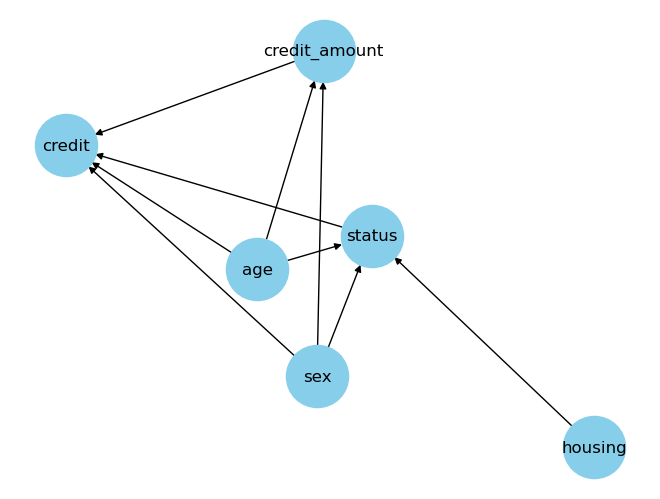

In [4]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit')])


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue")
plt.show()

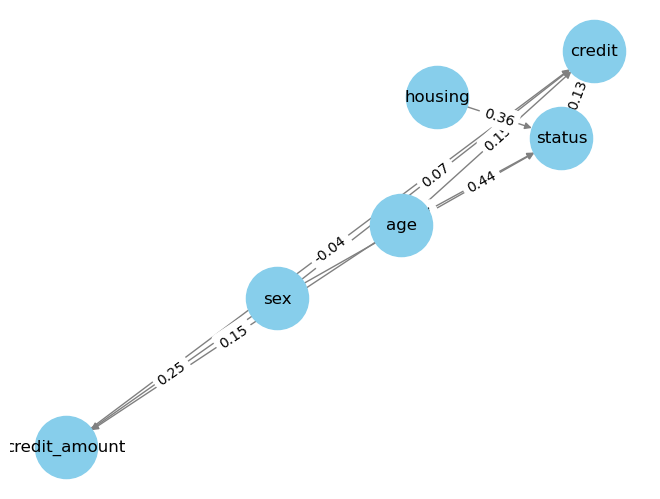

In [5]:
new_G=get_new_G(G,df)
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [6]:
ranks=get_ranking_query(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
5,3,1.0,1.046003,1,3,0,2.0,5.0,1.0,1,...,2.0,3.0,0.0,2.0,2.0,1.0,0,3.359667,0.0,2
1,3,0.0,0.000000,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.000000,2.0,0
7,3,1.0,1.046003,1,3,0,2.0,2.0,1.0,1,...,2.0,2.0,0.0,2.0,1.0,1.0,0,1.359667,3.0,0
3,3,1.0,1.046003,1,3,0,3.0,3.0,1.0,1,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.359667,2.0,0
17,3,0.0,1.000000,0,3,1,0.0,5.0,1.0,1,...,0.0,2.0,0.0,2.0,1.0,0.0,0,0.000000,2.0,2


### Simulating the ranking probility

In [7]:
base_line(df,5)

1.0100653517088042e-15

#### Backdoor adjustment probs

In [8]:
cgm=get_cgm(new_G)

In [9]:
%%time
df_back_prob=get_prob_backdoor_opt(get_ranking_query(new_G, df, len(df), {'housing':1}, 'credit_amount',{'age':1},'fix'),cgm,'credit_amount')

CPU times: user 658 ms, sys: 13.7 ms, total: 672 ms
Wall time: 675 ms


In [10]:
df_back_prob

,Y,Y_value,X,X_value,Z,prob
0,credit_amount,0,sex,1.0,"housing, age",0.274268
1,credit_amount,0,sex,0.0,"housing, age",0.381259
2,credit_amount,3,sex,1.0,"housing, age",0.181960
3,credit_amount,3,sex,0.0,"housing, age",0.120472
4,credit_amount,1,sex,1.0,"housing, age",0.323506
...,...,...,...,...,...,...
259,credit_amount,3,housing,0.0,,0.095238
260,credit_amount,1,housing,1.0,,0.314410
261,credit_amount,1,housing,0.0,,0.309524
262,credit_amount,2,housing,1.0,,0.209607


In [11]:
sorted_df = df_back_prob.sort_values(by=['Y_value', 'prob'], ascending=[False, False])
sorted_df

,Y,Y_value,X,X_value,Z,prob
61,credit_amount,3,status,1.359667,"housing, age, sex",0.391056
93,credit_amount,3,status,1.359667,"age, sex",0.391056
119,credit_amount,3,credit,0.046003,"housing, age, sex",0.308532
151,credit_amount,3,credit,0.046003,"age, sex",0.308532
59,credit_amount,3,status,0.359667,"housing, age, sex",0.217573
...,...,...,...,...,...,...
225,credit_amount,0,housing,0.000000,"age, sex",0.064375
131,credit_amount,0,credit,0.046003,"housing, age, sex, status",0.048423
163,credit_amount,0,credit,0.046003,"age, sex, status",0.048423
130,credit_amount,0,credit,1.046003,"housing, age, sex, status",0.033511


In [12]:
ranks_prob=get_ranking_query_prob(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks_prob

,row_index,1,2,3,4,5
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.005952,0.005952,0.005952,0.005952,0.005952
2,2,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.005952,0.005952,0.005952,0.005952,0.005952
4,4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
995,995,0.000000,0.000000,0.000000,0.000000,0.000000
996,996,0.000000,0.000000,0.000000,0.000000,0.000000
997,997,0.000000,0.000000,0.000000,0.000000,0.000000
998,998,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
ranks_prob_filtered=filter_prob_df(ranks_prob)
ranks_prob_filtered

,row_index,1,2,3,4,5
1,1,0.005952,0.005952,0.005952,0.005952,0.005952
3,3,0.005952,0.005952,0.005952,0.005952,0.005952
5,5,0.005952,0.005952,0.005952,0.005952,0.005952
7,7,0.005952,0.005952,0.005952,0.005952,0.005952
17,17,0.005952,0.005952,0.005952,0.005952,0.005952
...,...,...,...,...,...,...
973,973,0.005952,0.005952,0.005952,0.005952,0.005952
980,980,0.005952,0.005952,0.005952,0.005952,0.005952
983,983,0.005952,0.005952,0.005952,0.005952,0.005952
986,986,0.005952,0.005952,0.005952,0.005952,0.005952


In [14]:
get_probs(ranks_prob,[1, 3, 5, 7, 17])

7.934843523730395e-12

### Greedy algorithm

In [332]:
var=['sex', 'status', 'credit', 'age', 'housing']

In [333]:
df_gr=Greedy_Algo(new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [334]:
df_gr

,rank,prob,total_iters
0,"[5, 18, 7, 3, 29]",0.204,102.0
1,"[5, 7, 18, 3, 29]",0.098,49.0
2,"[7, 5, 18, 3, 29]",0.098,49.0
3,"[5, 1, 7, 3, 17]",0.600,300.0


In [335]:
most_probable_elements=get_most_probable_elements(df_gr)
most_probable_elements

,element,prob,total_iters
0,3,1.0,500.0
1,5,1.0,500.0
2,7,1.0,500.0
3,18,0.4,200.0
4,29,0.4,200.0
5,1,0.6,300.0
6,17,0.6,300.0


In [338]:
most_probable_elements['element']

0     3
1     5
2     7
3    18
4    29
5     1
6    17
Name: element, dtype: int64

In [339]:
k=1
for i in most_probable_elements['prob']:
    k*=i
print(k)

0.057600000000000005


### Calculate the Pr(r1>=theta1,r5>=theta1,r7>=theta1|given updates)

In [319]:
from causalgraphicalmodels import CausalGraphicalModel
import pandas as pd

def find_backdoor_sets_opt(cgm, Y, X):
    backdoor_sets = cgm.get_all_backdoor_adjustment_sets(Y, X)
    filtered_backdoor_sets = [bd_set for bd_set in backdoor_sets if bd_set]

    return filtered_backdoor_sets


def get_cgm(G):
    return CausalGraphicalModel(
        nodes=G.nodes,
        edges=G.edges)

# def backdoor_adjustment_opt(df, Y, y, A, a, Z):
#     prob = 0
#     total_len = len(df)
#     total_relevant_Z = 0  

#     unique_Z_combinations = df[Z].drop_duplicates()
#     for z_values in unique_Z_combinations.itertuples(index=False):
#         mask_Z = np.ones(len(df), dtype=bool)
#         for column, value in zip(Z, z_values):
#             mask_Z = mask_Z & (df[column] == value)
        
#         df_Z = df[mask_Z]
#         df_A_a_Z = df_Z[df_Z[A] == a]

#         if not df_A_a_Z.empty:
#             p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
#             p_Z = len(df_Z) / total_len
#             total_relevant_Z += len(df_Z)
#             prob += p_Y_given_A_Z * p_Z
#     if total_relevant_Z > 0:
#         prob = prob * total_len / total_relevant_Z

#     return prob

def backdoor_adjustment_opt(df, Y, y, A, a, Z):
    prob = 0
    total_len = len(df)
    total_relevant_Z = 0
    probz=0

    unique_Z_combinations = df[Z].drop_duplicates()
    for z_values in unique_Z_combinations.itertuples(index=False):
        mask_Z = np.ones(len(df), dtype=bool)
        for column, value in zip(Z, z_values):
            mask_Z = mask_Z & (df[column] == value)
        
        df_Z = df[mask_Z]
        df_A_a_Z = df_Z[df_Z[A] == a]

        if not df_A_a_Z.empty:
            p_Y_given_A_Z = (df_A_a_Z[Y] == y).sum() / len(df_A_a_Z)
            p_Z = len(df_Z) / total_len
            total_relevant_Z += len(df_Z)
            prob += p_Y_given_A_Z * p_Z
    if total_relevant_Z > 0:
        prob = prob * total_len / total_relevant_Z

    return prob,total_relevant_Z


def get_prob_backdoor_opt(df, cgm, y):
    nodes = cgm.graph.nodes
    results = []
    for node in nodes:
        if node != y:
            bd_sets = find_backdoor_sets_opt(cgm, y, node)
            for bd_set in bd_sets:
                dom_y = df[y].unique()
                dom_node = df[node].unique()
                for d_y in dom_y:
                    for d_n in dom_node:
                        adjusted_prob,Z_len = backdoor_adjustment_opt(df, y, d_y, node, d_n, list(bd_set))
                        results.append({
                            'Y': y, 
                            'Y_value': d_y, 
                            'X': node, 
                            'X_value': d_n, 
                            'Z': ', '.join(bd_set), 
                            'prob': adjusted_prob,
                            'Z_len':Z_len
                        })
    results_df = pd.DataFrame(results)
    results_df['Z_prob']=results_df['Z_len']/results_df['Z_len'].sum()
    return results_df


# def get_row_prob_back(prob_df, df, row_index, y, theta):
#     row = df.iloc[row_index]
#     Z_groups = []
#     prob_groups = []

#     for z in prob_df['Z'].unique():
#         z_relevant_probs = prob_df[
#             (prob_df['Z'] == z) & 
#             (prob_df['Y'] == y) & 
#             (prob_df['Y_value'] >= theta)
#         ]
#         if len(z_relevant_probs)==0:
#             Z_groups.append(z)
#             prob_groups.append(0)
            
#         else:
#             x_values_in_z_group = z_relevant_probs['X'].unique()
#             prob_product = 1
#             for x in x_values_in_z_group:
#                 if x in row.index:  
#                     x_value = row[x]
#                     x_prob = z_relevant_probs[
#                     (z_relevant_probs['X'] == x) & 
#                     (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
#                     prob_product *= x_prob
#             Z_groups.append(z)
#             prob_groups.append(prob_product)

#     return pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})

def get_row_prob_back(prob_df, df, row_index, y, theta):
    row = df.iloc[row_index]
    Z_groups = []
    prob_groups = []

    for z in prob_df['Z'].unique():
        z_relevant_probs = prob_df[
            (prob_df['Z'] == z) & 
            (prob_df['Y'] == y) & 
            (prob_df['Y_value'] >= theta)
        ]
        
        if len(z_relevant_probs)==0:
            Z_groups.append(z)
            prob_groups.append(0)
            
        else:
            x_values_in_z_group = z_relevant_probs['X'].unique()
            prob_product = 1
            for x in x_values_in_z_group:
                if x in row.index:  
                    x_value = row[x]
                    x_prob = z_relevant_probs[
                    (z_relevant_probs['X'] == x) & 
                    (z_relevant_probs['X_value'] == x_value)]['prob'].sum()
                    prob_product *= x_prob
            Z_groups.append(z)
            prob_groups.append(prob_product)

    return pd.DataFrame({'backdoor_path':Z_groups, 'prob':prob_groups})

def rec_row_prob_back(df, row_indexes, theta, cgm, y):
    prob_df = get_prob_backdoor_opt(df, cgm, y)

    total_prob = None
    backdoor_path = None

    for row_index in row_indexes:
        row_prob_df = get_row_prob_back(prob_df, df, row_index, y, theta)
        row_total_prob = row_prob_df['prob'].astype(float).to_numpy()

        if total_prob is None:
            total_prob = row_total_prob
        else:
            total_prob *= row_total_prob
        backdoor_path = row_prob_df['backdoor_path']

    return pd.DataFrame({'prob': total_prob, 'backdoor_path': backdoor_path,'prob_backdoor':1/len(total_prob)})

def get_sum_backdoor_prob(rec):
    return (rec['prob']*rec['prob_backdoor']).sum()
    

- step1 for each back door set we have$\sum_{i=1}^{n}Pr(Y=y|X=x,Z=z_i)Pr(Z=z_i)$
- step 2 we calculate $\sum_{j=1}^{n}Pr(Y=y_i|X=x)$ with $y_i \geq \theta$, 
- step 3 we calculate $\prod_{k=1}^{n}Pr(Y=y_1,y_2 ...|X=x_k)$ with $x_k$ is in the input r
- step 4 we multiply the $\prod_{L=1}^{n}Pr(Y=y_1,y_2 ...|X=x_1,x_2..., r_L)$ to get the Pr(r1>=theta1,r5>=theta1,r7>=theta1|given updates) for each backdoor path

In [284]:
updated_df=get_ranking_query(new_G, df, len(df), {'housing':2}, 'credit_amount',{'age':1},'add')

In [299]:
prob_df=get_prob_backdoor_opt(updated_df, cgm, 'credit_amount')

In [300]:
prob_df

,Y,Y_value,X,X_value,Z,prob,Z_len,Z_prob
0,credit_amount,0,sex,1.0,"housing, age",0.273355,1000,0.005954
1,credit_amount,0,sex,0.0,"housing, age",0.386514,1000,0.005954
2,credit_amount,3,sex,1.0,"housing, age",0.183646,1000,0.005954
3,credit_amount,3,sex,0.0,"housing, age",0.118452,1000,0.005954
4,credit_amount,1,sex,1.0,"housing, age",0.323167,1000,0.005954
...,...,...,...,...,...,...,...,...
299,credit_amount,1,housing,0.0,,0.000000,0,0.000000
300,credit_amount,2,housing,3.0,,0.000000,0,0.000000
301,credit_amount,2,housing,1.0,,0.000000,0,0.000000
302,credit_amount,2,housing,2.0,,0.000000,0,0.000000


In [301]:
prob_df[(prob_df['Z'] == 'age') &
        (prob_df['X'] == 'housing')&(prob_df['X_value']==3)]

,Y,Y_value,X,X_value,Z,prob,Z_len,Z_prob
240,credit_amount,0,housing,3.0,age,0.326194,810,0.004823
244,credit_amount,3,housing,3.0,age,0.135091,810,0.004823
248,credit_amount,1,housing,3.0,age,0.316310,810,0.004823
252,credit_amount,2,housing,3.0,age,0.222405,810,0.004823


In [276]:
prob_df['Z_len'].sum()

167948

In [302]:
prob_df[(prob_df['Z'] == 'age') &
        (prob_df['X'] == 'housing')&(prob_df['X_value']==3)].sum()

Y          credit_amountcredit_amountcredit_amountcredit_...
Y_value                                                    6
X                               housinghousinghousinghousing
X_value                                                 12.0
Z                                               ageageageage
prob                                                     1.0
Z_len                                                   3240
Z_prob                                              0.019292
dtype: object

In [303]:
prob_df['Z_prob'].sum()

1.0

$\sum Pr(top k |backdoor) Pr(backdoor)$

$Pr(backdoor)$ is missing

In [320]:
y='credit_amount'
cgm=get_cgm(new_G)
updated_df=get_ranking_query(new_G, df, len(df), {'housing':2}, 'credit_amount',{'age':1},'add')
rec_back=rec_row_prob_back(updated_df,[0,4,6],-np.inf,cgm,y)
prob_backdoor=get_sum_backdoor_prob(rec_back)
prob_backdoor

1.0

In [322]:
y='credit_amount'
cgm=get_cgm(new_G)
updated_df=get_ranking_query(new_G, df, len(df), {'housing':2}, 'credit_amount',{'age':1},'add')
rec_back2=rec_row_prob_back(updated_df,[0,4,6],1,cgm,y)
prob_backdoor2=get_sum_backdoor_prob(rec_back2)
prob_backdoor2

0.2505629981480648

- We have n backdoor paths, the backdoor prob is $\frac{1}{n}$

In [353]:
def Comp_Greedy_Algo_backdoor(row_indexes,G, df, k, target_column, vars_test,thresh_hold=0,condition=None,max_iter=100, opt="add",force=0.01):
    prob_result=[]
    cgm=get_cgm(new_G)
    
    if opt=='add'or 'subs':
        if opt=='add':
            pos=1
        else:
            pos=-1
        for var in vars_test:
            x_up=0
            x_sd = np.abs(df[var].std() * force)*pos
            for i in range(max_iter):
                x_up+=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column,condition,opt)
                theta=updated_df[target_column][k]
                rec_back=rec_row_prob_back(updated_df, row_indexes, theta, cgm, target_column)
                prob_backdoor=get_sum_backdoor_prob(rec_back)
                prob_result.append(prob_backdoor)
                
    elif opt=='multiply_by'or 'divided_by':
        if opt=='divided_by':
            def op_chang(x_sd):
                return 1/x_sd
        else:
            def op_chang(x_sd):
                return x_sd    
        for var in vars_test:
            x_up=0
            x_sd = op_chang(1+np.abs(df[var].std() * force))
            for i in range(max_iter):
                x_up*=x_sd
                updated_df=get_ranking_query(G, df, len(df), {var:x_up}, target_column,condition,opt)
                theta=updated_df[target_column][k]
                rec_back=rec_row_prob_back(updated_df, row_indexes, theta, cgm, target_column)
                prob_backdoor=get_sum_backdoor_prob(rec_back)
                prob_result.append(prob_backdoor)
    else:
        print('invalid operator, operator must be add,subs,multiply_by and divided_by')
    return prob_result

In [345]:
row_indexes=most_probable_elements['element'].tolist()
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [348]:
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

1.097301207443705e-06


In [349]:
greedy_backdoor2=Comp_Greedy_Algo_backdoor([5, 18, 7, 3, 29],new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [350]:
mean_value = sum(greedy_backdoor2) / len(greedy_backdoor2)
print(mean_value)

7.899782209515964e-05


In [354]:
greedy_backdoor3=Comp_Greedy_Algo_backdoor([3,5,7],new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [355]:
mean_value = sum(greedy_backdoor3) / len(greedy_backdoor3)
print(mean_value)

0.002858784660665528
